Introduction:

Business Problem: An e-commerce company wants to understand if they should implement the new page, keep the old page or perhaps run the experiment longer

To do this, we will run an A/B test on the data set that has been gathered over time. 

In [43]:
# To get started, lets import the necesary libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt  # basic visualizations
import seaborn as sns  # advanced visualizations

import random

random.seed(42)  # We are setting the seed to assure you get the same answers

import warnings

warnings.filterwarnings("ignore")

Import the dataset

In [44]:
data = "/Users/akeemraji/Desktop/Data Science/A_B_Test/ab_test.csv" 

df = pd.read_csv(data)

df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [45]:
#check the bottom 5 for consistency
df.tail()

,id,time,con_treat,page,converted
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0
294477,715931,40:24.5,treatment,new_page,0


In [46]:
#change column names for ease of understanding
df.columns = ["user_id", "timestamp", "group", "landing_page", "converted"]
df["user_id"] = df["user_id"].astype(str)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [47]:
# check number of rows and unique users
print(f"Number of rows: {df.shape[0]}")
print(f"Number of unique users: {df.user_id.nunique()}")

Number of rows: 294478
Number of unique users: 290584


In [48]:
# alternative method check number of rows and unique users
num_rows = df.shape[0] #to display rows alone df.shape displays rows and column
num_unique_users = df.user_id.nunique() #number of unique user

print("Number of rows:", num_rows) #ensures the string 'Number of rows:' is printed 
print("Number of unique users:", num_unique_users) #same

Number of rows: 294478
Number of unique users: 290584


In [49]:
# Check for duplicate rows across all columns
duplicates = df.duplicated()

# Print the duplicates
print(duplicates)

# To see the actual duplicate rows
print(df[duplicates])

0         False
1         False
2         False
3         False
4         False
          ...  
294473    False
294474    False
294475    False
294476    False
294477    False
Length: 294478, dtype: bool
Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


In [50]:
# General Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  object
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 11.2+ MB


In [51]:
# Check for missing Values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In the context of A/B testing, it's crucial for the integrity of the test that the treatment group size matches the size of the group exposed to the new treatment (in this case, the "new_page"). 

The code below is used to verify that the setup of the A/B test is correct, with an equal number of users in each critical segment. If there's a significant difference, it might indicate a problem in the experimental setup, such as users being incorrectly assigned to groups or pages.

In [52]:
# Filter the DataFrame for the treatemet group and count the entries
treatment_group = df[df["group"] == "treatment"]
num_treatment = treatment_group.shape[0]

# Filter the DataFrame for users who saw the new page and count the entries
new_page_users = df[df["landing_page"] == "new_page"]
num_new_page = new_page_users.shape[0]

#Difference between users in treatment group vs users who saw new page
difference = num_treatment - num_new_page

#create DataFrame to display in a structured format
comparison_df = pd.DataFrame({
    'Number in Treatment': [num_treatment],
    'Number with New Page': [num_new_page],
    'difference': [difference]
})

#Display Comparison Data
print(comparison_df)

   Number in Treatment  Number with New Page  difference
0               147276                147239          37


In [53]:
# alternative method
# Does the number of new_page and treatment match?
n_treat = df[df["group"] == "treatment"].shape[0]
n_new_page = df[df["landing_page"] == "new_page"].shape[0]
difference = n_treat - n_new_page

pd.DataFrame(
    {"N treatment": [n_treat], "N new_page": [n_new_page], "Difference": [difference]}
)

,N treatment,N new_page,Difference
0,147276,147239,37


From the above results, it is obvious there is a mismatch between the number of users assigned to the treatment group and the number of those that landed on the treatment page (new page). This might indicate a problem with the data and needs further exploration

In [54]:
# Does the number of old_page and control match?
n_control = df[df["group"] == "control"].shape[0]
n_old_page = df[df["landing_page"] == "old_page"].shape[0]
difference = n_control - n_old_page

pd.DataFrame(
    {"N control": [n_control], "N old_page": [n_old_page], "Difference": [difference]}
)

,N control,N old_page,Difference
0,147202,147239,-37


Same with the control.

lets check for the mismatch

In [55]:
#lets see the rows. Starting with treatment and old_page
df[(df["group"] == "treatment") & (df["landing_page"] == "old_page")]

,user_id,timestamp,group,landing_page,converted
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
685,666385,11:54.8,treatment,old_page,0
713,748761,47:44.4,treatment,old_page,0
...,...,...,...,...,...
293773,688144,34:50.5,treatment,old_page,1
293817,876037,15:09.0,treatment,old_page,1
293917,738357,37:55.7,treatment,old_page,0
294014,813406,25:33.2,treatment,old_page,0


In [56]:
# lets see the rows. Next is control and new_page
df[(df["group"] == "control") & (df["landing_page"] == "new_page")]

,user_id,timestamp,group,landing_page,converted
22,767017,58:15.0,control,new_page,0
240,733976,11:16.4,control,new_page,0
490,808613,44:01.3,control,new_page,0
846,637639,09:52.7,control,new_page,1
850,793580,25:33.7,control,new_page,1
...,...,...,...,...,...
293894,741581,49:03.4,control,new_page,0
293996,942612,52:28.2,control,new_page,0
294200,928506,32:10.5,control,new_page,0
294253,886135,49:20.5,control,new_page,0


The result above shows a significant mis-match in both control and treatment group
control mistmatch = 1928
treatment mismatch = 1965

In [57]:
# Calculate total mismatch rows and percentage of data mismatched

df_mismatch = df[
    ((df["group"] == "treatment") & (df["landing_page"] == "old_page"))
    | ((df["group"] == "control") & (df["landing_page"] == "new_page"))
] # & and | are used in panda to combine 2 sets of conditions, however & takes precidence over |, thus executed first

n_mismatch = df_mismatch.shape[0] #number of mismatch

percent_mismatch = round(n_mismatch / len(df) * 100, 2) #% mismatch to 2 decimal places

print(f'Number of mismatched rows: {n_mismatch} rows') #print 
print(f'Percent of mismatched rows: {percent_mismatch} %') #print


Number of mismatched rows: 3893 rows
Percent of mismatched rows: 1.32 %


As seen above, there are a total of 3893 rows where treatment does not match with new_page or control does not match with old_page, we cannot be sure if this row truly received the new or old page. 

How do we handle this?

Answer: create a new DataFrame that excludes the mismatch

In [58]:
#creating new DataFrame
df_new = df[
    ((df["group"] == "treatment") & (df["landing_page"] == "new_page"))
    | ((df["group"] == "control") & (df["landing_page"] == "old_page"))
]

len(df_new)

290585

In [59]:
df_new.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [60]:
# Double Check all of the correct rows were removed - this should be 0
df_new[
    ((df_new["group"] == "treatment") == (df_new["landing_page"] == "new_page")) == False
].shape[0]

0

In [61]:
# Alternative Approach

# Step 1: Identify rows where treatment group doesn't match new_page
treatment_mismatch = (df_new["group"] == "treatment") & (df_new["landing_page"] != "new_page")

# Step 2: Identify rows where control group doesn't match old_page
control_mismatch = (df_new["group"] == "control") & (df_new["landing_page"] != "old_page")

# Combine the two mismatch conditions
any_mismatch = treatment_mismatch | control_mismatch

# Count the number of mismatches
num_mismatches = any_mismatch.sum()

# Percent Mismatch
Percent_mismatch = round(num_mismatches / len(df_new) * 100, 2)

# Print the number of mismatches
print(f"Number of mismatches: {num_mismatches}")
print(f"Percent of mismatched rows: {Percent_mismatch} percent")

Number of mismatches: 0
Percent of mismatched rows: 0.0 percent


In [62]:
# check for unique user id in df_new
df_new.user_id.nunique()

290584

In [63]:
# check for repeated user id in df_new
len(df_new) - df_new.user_id.nunique()

1

In [64]:
# display the duploicated row
df_new[df_new.duplicated("user_id") == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


In [65]:
# drop duplicated row
df_new = df_new.drop_duplicates("user_id")

In [66]:
# Double check that it has been dropped
len(df_new) - df_new.user_id.nunique()

0

PART 2 of Analysis - Probability

In [67]:
# Percent of Convergence
# i.e the probability of a user converting irrespective of the page received
df_new.converted.mean() * 100

11.959708724499627

In [68]:
# Given that an individual was in the control group, what is the probability they converted?
# Given that an individual was in the treatment group, what is the probability they converted?

# Since 'converted' is the column indicating whether a user converted (1) or not (0)
conversion_rates = df_new.groupby("group")["converted"].mean() * 100

# Display the conversion rates
print(conversion_rates)

group
control      12.038630
treatment    11.880807
Name: converted, dtype: float64


In [69]:
# Probability that an individual received a new page?
# df_new.landing_page.value_counts(normalize= True)returns a Series where the index consists of unique values from the landing_page column ("new_page" and "old_page"), and the values represent the proportion of each unique value in the column.
# * 100: This converts the proportions to percentages
# pd.DataFrame(...): This converts the Series into a DataFrame, making it easier to read and potentially allowing for more complex manipulations later on.

pd.DataFrame(df_new.landing_page.value_counts(normalize= True) *100)

,proportion
landing_page,
new_page,50.006194
old_page,49.993806


Is there a sufficient evidence to conclude that the new treatment page leads to more conversions?

1. The probability that an individual received the new page is 50%
2. The probability of an individual converting regardless of the page they receive is 11.96%
3. Given that an individual was in the control group, the probability they converted is 12.04%
4. Given that an individual was in the treatment group, the probability they converted is 11.88%

1 to 4 suggests that there is no significant difference in convergence between treatment and control groups. Therefore we may conclude that the new treatment page has no impact and does not lead to more conversions.

Part III - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

𝐻0 :  𝑝𝑜𝑙𝑑  -  𝑝𝑛𝑒𝑤   >=0 

𝐻1 :  𝑝𝑜𝑙𝑑  -  𝑝𝑛𝑒𝑤   <0 

In [70]:
# Creating the sampling distribution of difference in means
means_diff = []
size = df_new.shape[0]
for _ in range(1000):
    sample = df_new.sample(size, replace=True)
    control_mean = sample[sample["group"] == "control"]["converted"].mean()
    treat_mean = sample[sample["group"] == "treatment"]["converted"].mean()
    means_diff.append(treat_mean - control_mean)

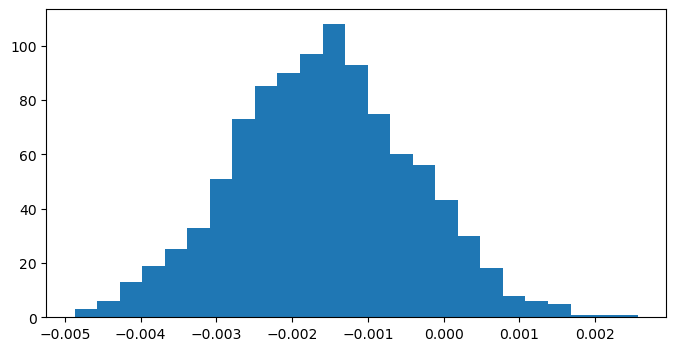

In [71]:
# Plotting the sampling distribution
# histogram of the sampling distribution of the difference in means between the treatment and control groups that you obtained from the bootstrapping process in your previous step
# This visualization can help you understand the variability in the difference in means and potentially infer whether the treatment had a significant effect
plt.figure(figsize=(8, 4), dpi=100)
plt.hist(means_diff, bins=25)
plt.show()

In [72]:
# Simulate distribution under the null hypothesis
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

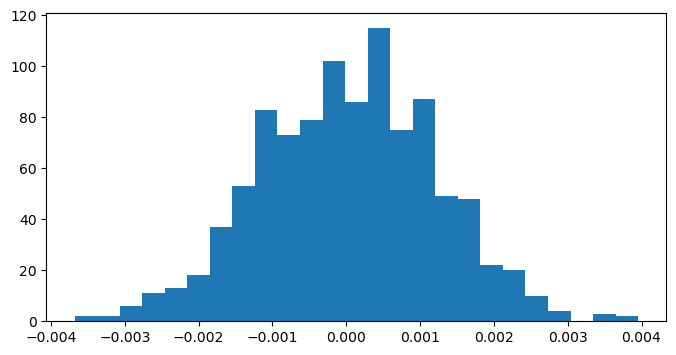

In [73]:
# Plot the null distribution
# The null distribution represents the distribution of the difference in means that you would expect to see if there were no effect from the treatment; that is, if the null hypothesis were true.
plt.figure(figsize=(8, 4), dpi=100)
plt.hist(null_vals, bins=25)
plt.show()

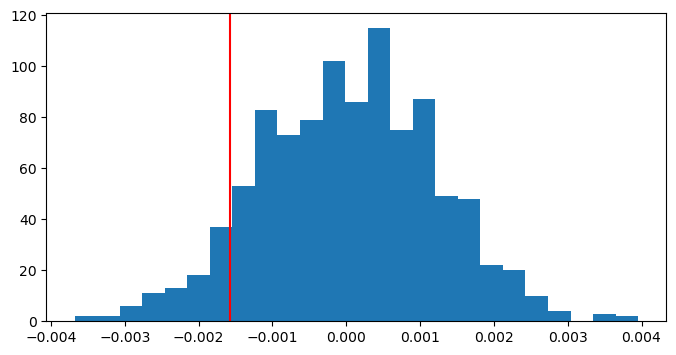

In [74]:
# Plot observed statistic with the null distibution
# the observed difference in conversion rates (the observed statistic) alongside the null distribution
# This visual comparison is crucial in hypothesis testing to determine how extreme the observed statistic is within the context of the null hypothesis.
control_mean = df_new[df_new["group"] == "control"]["converted"].mean()
treat_mean = df_new[df_new["group"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize=(8, 4), dpi=100)
plt.hist(null_vals, bins=25)
plt.axvline(obs_diff, c="red")
plt.show()

note that the histogram itself doesn't provide statistical significance levels or confidence intervals; it merely visualizes the estimated distribution of the effect.

To draw conclusions, visual assessment can be supplemented with a calculation of the p-value, which quantifies the probability of observing a statistic as extreme as, or more extreme than, the observed statistic under the null hypothesis. 

In [75]:
# calculating the p value
(null_vals > obs_diff).mean()

0.915

Concluding remarks for this section so far:

1. The p_value (0.9) is greater than alpha, therefore we fail to reject the null.
2. This emphasizes of initial conclusion that there is no significant impact for the new page.

We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [76]:
import statsmodels.api as sm

convert_old = df_new[(df_new["converted"] == 1) & (df_new["landing_page"] == "old_page")][
    "user_id"
].nunique()
convert_new = df_new[(df_new["converted"] == 1) & (df_new["landing_page"] == "new_page")][
    "user_id"
].nunique()
n_old = df_new[df_new["landing_page"] == "old_page"]["user_id"].nunique()
n_new = df_new[df_new["landing_page"] == "new_page"]["user_id"].nunique()

In [77]:
# Compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(
    np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative="larger"
)

In [78]:
# Print Z Score and P_Value
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

Using test statistic and p-value, we reach the same coclusion: we can not reject the null

Finally, A/B Test Using Regression Analysis

- First, we will create a column 'intercept' for which page each user received.

In [79]:
# create the intercept
df_new["intercept"] = 1
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,11:48.6,control,old_page,0,1
1,804228,01:45.2,control,old_page,0,1
2,661590,55:06.2,treatment,new_page,0,1
3,853541,28:03.1,treatment,new_page,0,1
4,864975,52:26.2,control,old_page,1,1


In [80]:
# Create ab_page column, which is 1 when an individual receives the treatment and 0 if control
df_new["ab_page"] = df_new.group.apply(lambda x: 1 if(x == "treatment") else 0)
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,11:48.6,control,old_page,0,1,0
1,804228,01:45.2,control,old_page,0,1,0
2,661590,55:06.2,treatment,new_page,0,1,1
3,853541,28:03.1,treatment,new_page,0,1,1
4,864975,52:26.2,control,old_page,1,1,0


In [81]:
# Initiate and fit Logistic Regression model to dependend and independent variables
model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 28 Mar 2024   Pseudo R-squ.:               8.077e-06
Time:                        18:02:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The P-Value is 0.190, It is different from the one we obtained from the previous analysis because the null hypothesis is different in both cases.

We might add additional features to our model such timestamp, the reason for that conversion might differ according to the time at which the user visits the website. But this might come with a disadvantage, the model will become more complicated and less interpretable. It might be also susceptible to overfitting.

We will leave timestamp for now. Instead, along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives in. we will need to read in the countries.csv dataset and merge together your datasets on the appropriate rows.

In [82]:
countries = pd.read_csv(
    "/Users/akeemraji/Desktop/Data Science/A_B_Test/countries_ab.csv"
)
countries.head()

,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [83]:
# Merge countries DataFrame with df_new
countries.columns = ["user_id", "country"] #rename columns for consistensy
countries["user_id"] = countries["user_id"].astype(str) #define datatype
df1 = df_new.merge(countries, on = "user_id", how = "left") #merge on user_id using left join
df1.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,11:48.6,control,old_page,0,1,0,US
1,804228,01:45.2,control,old_page,0,1,0,US
2,661590,55:06.2,treatment,new_page,0,1,1,US
3,853541,28:03.1,treatment,new_page,0,1,1,US
4,864975,52:26.2,control,old_page,1,1,0,US


In [84]:
# creating dummies for country and landing_page columns
df1[['CA', 'UK', 'US']] = pd.get_dummies(df1['country'])
df1[['new_page', 'old_page']] = pd.get_dummies(df1['landing_page'])
df1.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,new_page,old_page
0,851104,11:48.6,control,old_page,0,1,0,US,False,False,True,False,True
1,804228,01:45.2,control,old_page,0,1,0,US,False,False,True,False,True
2,661590,55:06.2,treatment,new_page,0,1,1,US,False,False,True,True,False
3,853541,28:03.1,treatment,new_page,0,1,1,US,False,False,True,True,False
4,864975,52:26.2,control,old_page,1,1,0,US,False,False,True,False,True


In [85]:
# creating dummies for country and landing_page columns with true and False as 1 and 0 using astype() function
df1[["CA", "UK", "US"]] = pd.get_dummies(df1["country"]).astype(int)
df1[["new_page", "old_page"]] = pd.get_dummies(df1["landing_page"]).astype(int)
df1.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,new_page,old_page
0,851104,11:48.6,control,old_page,0,1,0,US,0,0,1,0,1
1,804228,01:45.2,control,old_page,0,1,0,US,0,0,1,0,1
2,661590,55:06.2,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,28:03.1,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,52:26.2,control,old_page,1,1,0,US,0,0,1,0,1


In [86]:
# check for relationship between country and conversion
pd.pivot_table(data = df1, index = 'country', values= 'converted').sort_values(by='converted', ascending=False) * 100 #mean is the default aggregate

,converted
country,
UK,12.059449
US,11.954680
CA,11.531830


It seems that coutry has a very minor impact on convergance. we will see its true impact along with ather features in the regression# Instantiate and fit the regression model. 
- model = sm.Logit(df2['converted'], df2[['intercept','ab_page']]) 
- result = model.fit() 
- result.summary()
- Instantiate and fit the regression model model = sm.Logit(df2['converted'], df2[['intercept','ab_page']]) result = model.fit() result.summary()

In [87]:
# Initiate and fit Logistic Regression model to dependend and independent variables with country as an additional variable
# 'CA' is a baseline 
model = sm.Logit(df1["converted"], df1[["intercept", "ab_page", "UK", "US"]])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 28 Mar 2024   Pseudo R-squ.:               2.323e-05
Time:                        18:02:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [88]:
# interprete results
# exponentiate the parameters to inteprete the result
np.exp(result.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

- All the coefficients are statistically insignificant except the intercept. This comes inline with the initial conclusions that we have just made.


Summary:
In this notebook we conducted a detailed A/B testing using 3 main methods:

- Sampling distribution
- Z test
- Logestic regression
All three methods resulted in the same conclusion: the treatment has no impact.